/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.6926567798463017


/opt/homebrew/lib/python3.11/site-packages/minisom.py:164: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


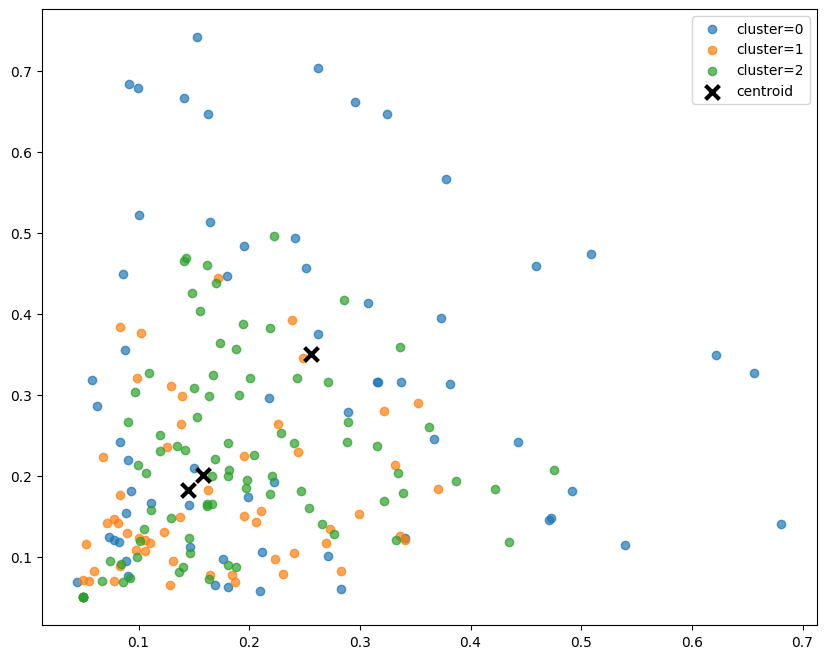

       topic_0   topic_1   topic_2   topic_3   topic_4  topic_5  topic_6  \
90    0.243889  0.229921  0.502482  0.000000  0.000000      0.0      0.0   
678   0.052792  0.115198  0.427639  0.202603  0.193946      0.0      0.0   
1739  0.068025  0.222902  0.518213  0.181530  0.000000      0.0      0.0   
680   0.105777  0.120740  0.412047  0.345735  0.000000      0.0      0.0   
3034  0.217700  0.296102  0.308998  0.157641  0.000000      0.0      0.0   

      topic_7  topic_8  topic_9  ...       192       193       194       195  \
90        0.0      0.0      0.0  ... -0.034365 -0.034073  0.079964  0.077882   
678       0.0      0.0      0.0  ... -0.081869  0.009513  0.061093  0.044262   
1739      0.0      0.0      0.0  ... -0.111313 -0.007199  0.058469  0.056886   
680       0.0      0.0      0.0  ... -0.064995 -0.043380  0.033978  0.050460   
3034      0.0      0.0      0.0  ... -0.075040  0.003186  0.111387  0.022475   

           196       197       198       199  Distance  cluste

/opt/homebrew/lib/python3.11/site-packages/shap/plots/_beeswarm.py:962: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
/opt/homebrew/lib/python3.11/site-packages/shap/plots/_beeswarm.py:636: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


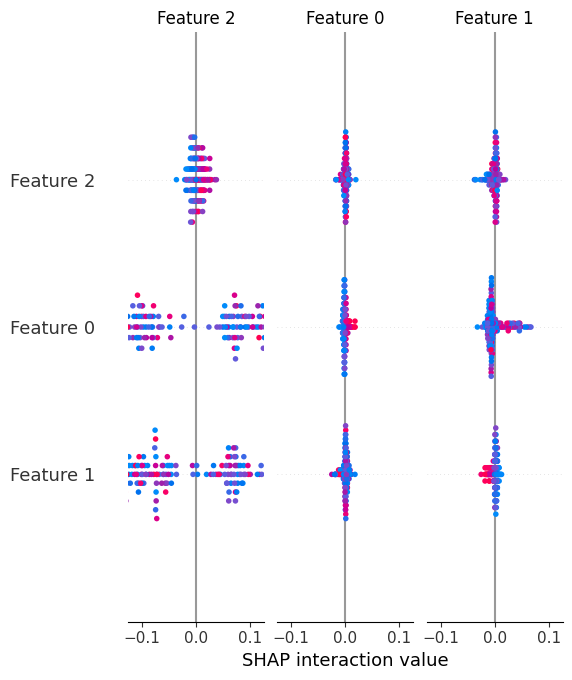

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
import shap
from minisom import MiniSom

# Load the data
df = pd.read_csv('./data/merged.csv')
df.drop('Index', axis=1, inplace=True)

# Convert NaN values to 0 in each column
df = df.fillna(0)

# Function to get user input
def get_user_input():
    doc_index = int(input("Enter the document index (0 to 17999): "))
    num_neighbors = int(input("Enter the number of neighbors: "))
    return doc_index, num_neighbors

# Function to fit the KNN model
def fit_knn_model(features):
    knn = NearestNeighbors(n_neighbors=features.shape[0])  # Use maximum number of neighbors
    knn.fit(features)
    return knn

# Function to get nearest neighbors
def get_nearest_neighbors(knn, features, doc_index, num_neighbors):
    distances, indices = knn.kneighbors(features.iloc[doc_index].values.reshape(1, -1), n_neighbors=num_neighbors + 1)
    # Exclude the first neighbor as it is the document itself
    return indices.flatten()[1:], distances.flatten()[1:]

# Fit KNN model
knn_model = fit_knn_model(df)

# Get user input
doc_index, num_neighbors = get_user_input()

# Get nearest neighbors
neighbor_indices, neighbor_distances = get_nearest_neighbors(knn_model, df, doc_index, num_neighbors)

# Retrieve the nearest neighbors from the original DataFrame
neighbors_df = df.iloc[neighbor_indices].copy()
neighbors_df['Distance'] = neighbor_distances

# SOM Training
k = int(input("Enter the number of clusters: "))
som_shape = (1, k)

# Extract features for SOM training (excluding 'Distance' column)
features_for_som = neighbors_df.drop(columns=['Distance']).values

# Initialize and train SOM
som = MiniSom(som_shape[0], som_shape[1], features_for_som.shape[1], sigma=1.0, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(features_for_som, 1000, verbose=True)

# Assign each data point to a cluster
win_map = som.win_map(features_for_som)
cluster_index = np.zeros(features_for_som.shape[0], dtype=int)

for i, x in enumerate(features_for_som):
    w = som.winner(x)
    cluster_index[i] = w[1]  # since som_shape is (1, k), we use the second index

# Plotting the clusters using the first 2 dimensions of the data
plt.figure(figsize=(10, 8))
for c in np.unique(cluster_index):
    plt.scatter(features_for_som[cluster_index == c, 0],
                features_for_som[cluster_index == c, 1], label='cluster=' + str(c), alpha=.7)

# Plotting centroids
centroids = som.get_weights().reshape(-1, features_for_som.shape[1])
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x',
            s=100, linewidths=3, color='k', label='centroid')

plt.legend()
plt.show()

# Display cluster assignment for each data point
neighbors_df['cluster'] = cluster_index
print(neighbors_df.head())

# Check for empty clusters
empty_clusters = [c for c in range(k) if np.sum(cluster_index == c) == 0]
print(f"Empty clusters: {empty_clusters}")

# Compute the Calinski-Harabasz Index
if len(empty_clusters) == 0:  # Compute only if there are no empty clusters
    from sklearn.metrics import calinski_harabasz_score
    ch_score = calinski_harabasz_score(features_for_som, cluster_index)
    print(f"Calinski-Harabasz Index: {ch_score}")
else:
    print("Cannot compute Calinski-Harabasz Index due to empty clusters.")

# Train a supervised model to predict cluster assignments
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features_for_som, cluster_index)

# Use SHAP to explain the supervised model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(features_for_som)

# Summary plot for all clusters
shap.summary_plot(shap_values, features_for_som)


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.629118737985802


/opt/homebrew/lib/python3.11/site-packages/minisom.py:164: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


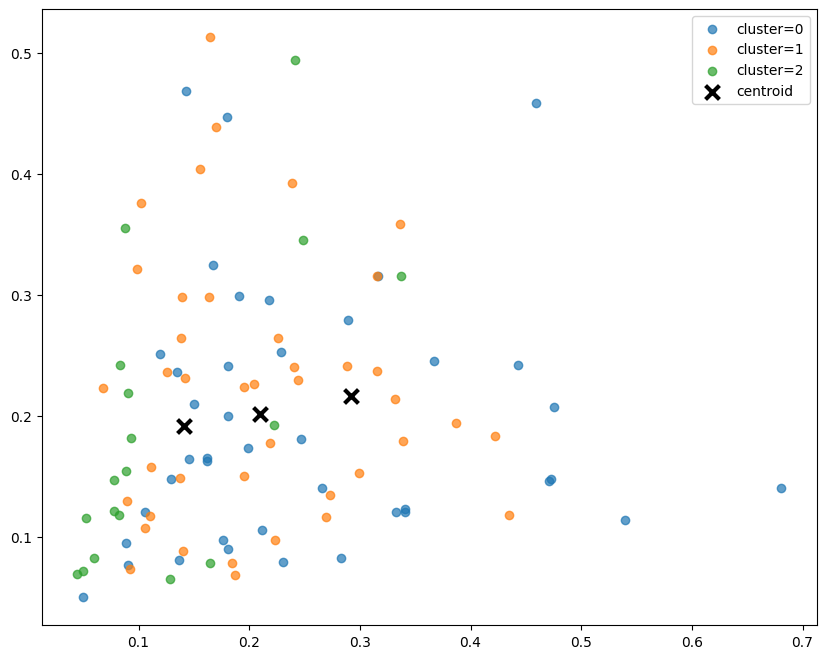

       topic_0   topic_1   topic_2   topic_3   topic_4  topic_5  topic_6  \
90    0.243889  0.229921  0.502482  0.000000  0.000000      0.0      0.0   
678   0.052792  0.115198  0.427639  0.202603  0.193946      0.0      0.0   
1739  0.068025  0.222902  0.518213  0.181530  0.000000      0.0      0.0   
680   0.105777  0.120740  0.412047  0.345735  0.000000      0.0      0.0   
3034  0.217700  0.296102  0.308998  0.157641  0.000000      0.0      0.0   

      topic_7  topic_8  topic_9  ...       192       193       194       195  \
90        0.0      0.0      0.0  ... -0.034365 -0.034073  0.079964  0.077882   
678       0.0      0.0      0.0  ... -0.081869  0.009513  0.061093  0.044262   
1739      0.0      0.0      0.0  ... -0.111313 -0.007199  0.058469  0.056886   
680       0.0      0.0      0.0  ... -0.064995 -0.043380  0.033978  0.050460   
3034      0.0      0.0      0.0  ... -0.075040  0.003186  0.111387  0.022475   

           196       197       198       199  Distance  cluste

/opt/homebrew/lib/python3.11/site-packages/shap/plots/_beeswarm.py:962: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
/opt/homebrew/lib/python3.11/site-packages/shap/plots/_beeswarm.py:636: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


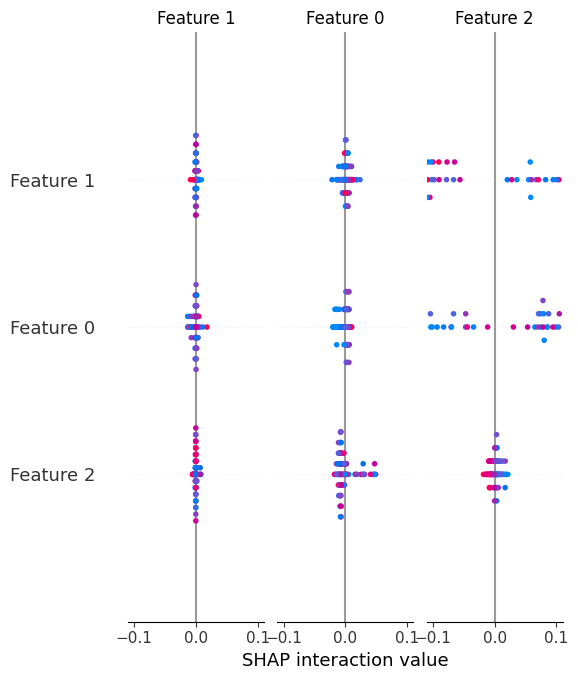

NotImplementedError: matplotlib = True is not yet supported for force plots with multiple samples!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
import shap
from minisom import MiniSom

# Load the data
df = pd.read_csv('./data/merged.csv')
df.drop('Index', axis=1, inplace=True)

# Convert NaN values to 0 in each column
df = df.fillna(0)

# Function to get user input
def get_user_input():
    doc_index = int(input("Enter the document index (0 to 17999): "))
    num_neighbors = int(input("Enter the number of neighbors: "))
    return doc_index, num_neighbors

# Function to fit the KNN model
def fit_knn_model(features):
    knn = NearestNeighbors(n_neighbors=features.shape[0])  # Use maximum number of neighbors
    knn.fit(features)
    return knn

# Function to get nearest neighbors
def get_nearest_neighbors(knn, features, doc_index, num_neighbors):
    distances, indices = knn.kneighbors(features.iloc[doc_index].values.reshape(1, -1), n_neighbors=num_neighbors + 1)
    # Exclude the first neighbor as it is the document itself
    return indices.flatten()[1:], distances.flatten()[1:]

# Fit KNN model
knn_model = fit_knn_model(df)

# Get user input
doc_index, num_neighbors = get_user_input()

# Get nearest neighbors
neighbor_indices, neighbor_distances = get_nearest_neighbors(knn_model, df, doc_index, num_neighbors)

# Retrieve the nearest neighbors from the original DataFrame
neighbors_df = df.iloc[neighbor_indices].copy()
neighbors_df['Distance'] = neighbor_distances

# SOM Training
k = int(input("Enter the number of clusters: "))
som_shape = (1, k)

# Extract features for SOM training (excluding 'Distance' column)
features_for_som = neighbors_df.drop(columns=['Distance']).values

# Initialize and train SOM
som = MiniSom(som_shape[0], som_shape[1], features_for_som.shape[1], sigma=1.0, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(features_for_som, 1000, verbose=True)

# Assign each data point to a cluster
win_map = som.win_map(features_for_som)
cluster_index = np.zeros(features_for_som.shape[0], dtype=int)

for i, x in enumerate(features_for_som):
    w = som.winner(x)
    cluster_index[i] = w[1]  # since som_shape is (1, k), we use the second index

# Plotting the clusters using the first 2 dimensions of the data
plt.figure(figsize=(10, 8))
for c in np.unique(cluster_index):
    plt.scatter(features_for_som[cluster_index == c, 0],
                features_for_som[cluster_index == c, 1], label='cluster=' + str(c), alpha=.7)

# Plotting centroids
centroids = som.get_weights().reshape(-1, features_for_som.shape[1])
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x',
            s=100, linewidths=3, color='k', label='centroid')

plt.legend()
plt.show()

# Display cluster assignment for each data point
neighbors_df['cluster'] = cluster_index
print(neighbors_df.head())

# Check for empty clusters
empty_clusters = [c for c in range(k) if np.sum(cluster_index == c) == 0]
print(f"Empty clusters: {empty_clusters}")

# Compute the Calinski-Harabasz Index
if len(empty_clusters) == 0:  # Compute only if there are no empty clusters
    from sklearn.metrics import calinski_harabasz_score
    ch_score = calinski_harabasz_score(features_for_som, cluster_index)
    print(f"Calinski-Harabasz Index: {ch_score}")
else:
    print("Cannot compute Calinski-Harabasz Index due to empty clusters.")

# Train a supervised model to predict cluster assignments
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features_for_som, cluster_index)

# Use SHAP to explain the supervised model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(features_for_som)

# Summary plot for all clusters
shap.summary_plot(shap_values, features_for_som)

# Force plot for a specific instance (e.g., the first instance)
instance_idx = 0  # You can change this index to any instance you want to explain
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value[cluster_index[instance_idx]],
                             shap_values[cluster_index[instance_idx]],
                             features_for_som[instance_idx],
                             matplotlib=True)
plt.show()
